[*********************100%%**********************]  1 of 1 completed


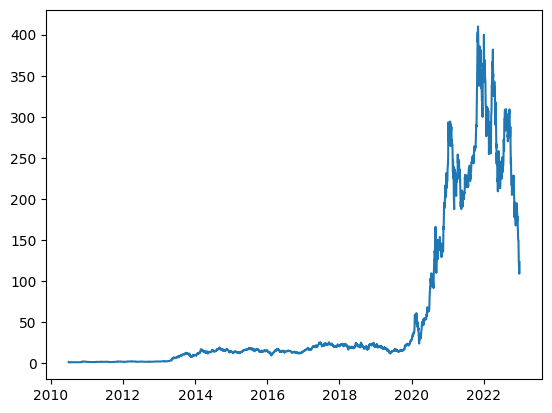

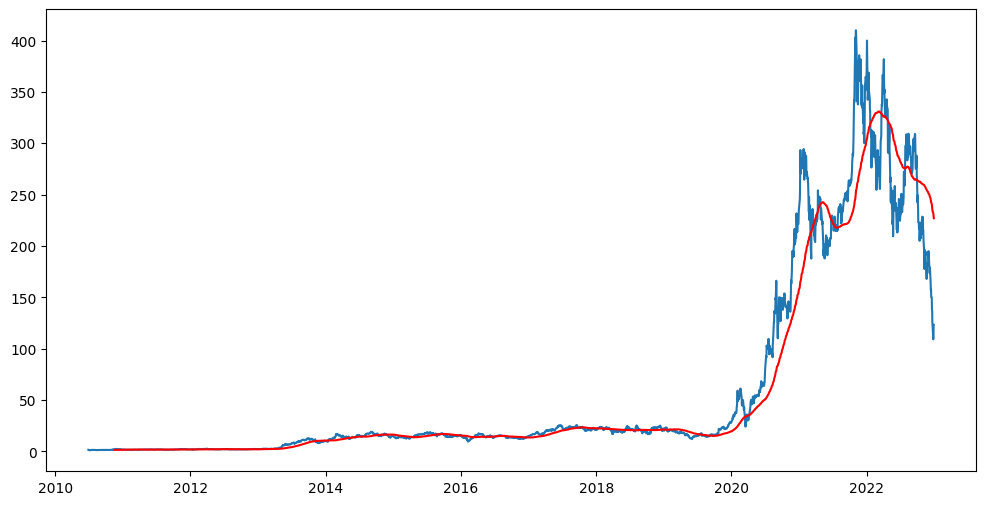

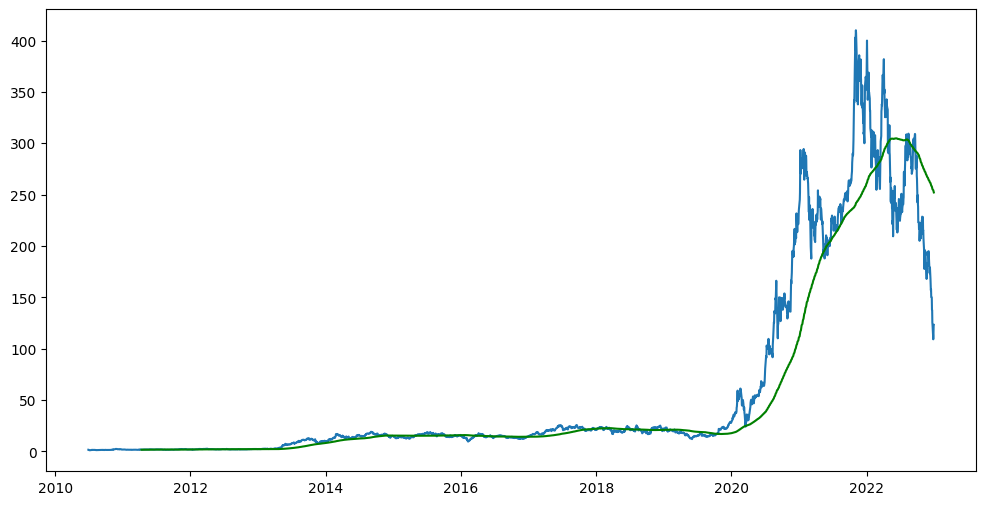

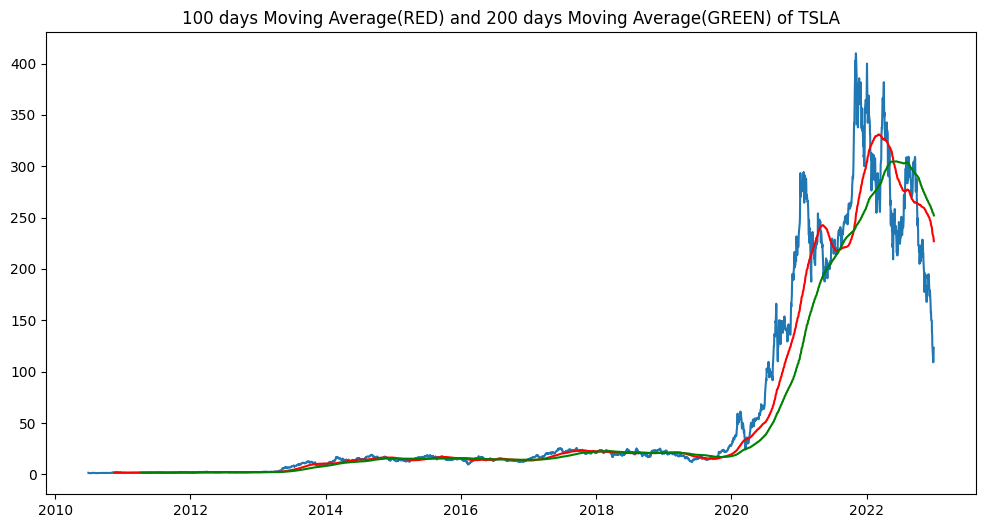

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt 
import yfinance as yf
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Load Data
company = 'TSLA'
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2023, 1, 1)

data = yf.download(company, start=start, end=end)

# Plot Closing Prices
plt.plot(data['Close'])
plt.show()

# Calculate 100 days moving average
ma100 = data['Close'].rolling(100).mean()

# Plot Closing Prices with 100 days moving average
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.plot(ma100, 'r')
plt.show()

# Calculate 200 days moving average
ma200 = data['Close'].rolling(200).mean()

# Plot Closing Prices with 200 days moving average
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.plot(ma200, 'g')
plt.show()

# Plot Closing Prices with 100 and 200 days moving averages
plt.figure(figsize=(12, 6))
plt.title(f"100 days Moving Average(RED) and 200 days Moving Average(GREEN) of {company}")
plt.plot(data['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.show()

# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [15]:
#Build The Model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)






Epoch 1/25
97/97 [==============================] - 9s 47ms/step - loss: 0.0050
Epoch 2/25
97/97 [==============================] - 4s 45ms/step - loss: 0.0019
Epoch 3/25
97/97 [==============================] - 4s 46ms/step - loss: 0.0016
Epoch 4/25
97/97 [==============================] - 5s 49ms/step - loss: 0.0015
Epoch 5/25
97/97 [==============================] - 4s 46ms/step - loss: 0.0014
Epoch 6/25
97/97 [==============================] - 4s 43ms/step - loss: 0.0015
Epoch 7/25
97/97 [==============================] - 4s 43ms/step - loss: 0.0012
Epoch 8/25
97/97 [==============================] - 5s 48ms/step - loss: 0.0011
Epoch 9/25
97/97 [==============================] - 6s 58ms/step - loss: 0.0015
Epoch 10/25
97/97 [==============================] - 6s 57ms/step - loss: 0.0012
Epoch 11/25
97/97 [==============================] - 6s 61ms/step - loss: 0.0011
Epoch 12/25
97/97 [==============================] - 6s 57ms/step - loss: 0.0011
Epoch 13/25
97/97 [==================

In [16]:
# Save the model in the native Keras format 
model.save('my_model.h5')  

[*********************100%%**********************]  1 of 1 completed
[[[0.57976769]
  [0.54293868]
  [0.54266967]
  ...
  [0.27305482]
  [0.2953332 ]
  [0.29865906]]

 [[0.54293868]
  [0.54266967]
  [0.52687181]
  ...
  [0.2953332 ]
  [0.29865906]
  [0.97543916]]

 [[0.54266967]
  [0.52687181]
  [0.52868149]
  ...
  [0.29865906]
  [0.97543916]
  [0.93452616]]

 ...

 [[0.57820258]
  [0.5854412 ]
  [0.5720155 ]
  ...
  [0.42731606]
  [0.42592215]
  [0.40491544]]

 [[0.5854412 ]
  [0.5720155 ]
  [0.5695211 ]
  ...
  [0.42592215]
  [0.40491544]
  [0.40919504]]

 [[0.5720155 ]
  [0.5695211 ]
  [0.55308743]
  ...
  [0.40491544]
  [0.40919504]
  [0.41587121]]]
18/18 [==============================] - 1s 14ms/step
Mean Squared Error (MSE): 447.5434814595726
Root Mean Squared Error (RMSE): 21.15522350294538
Mean Absolute Error (MAE): 11.810257819174039


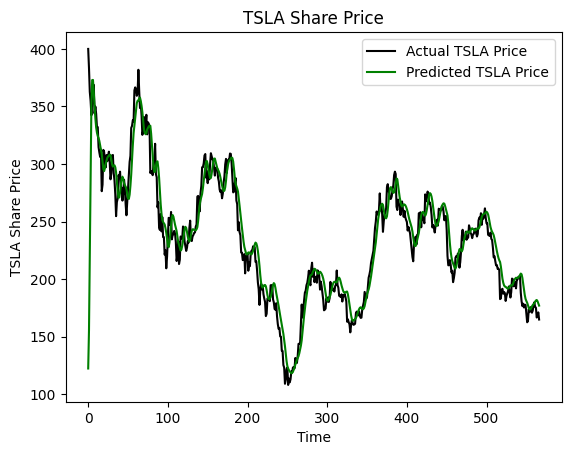

1/1 [==============================] - 0s 37ms/step
Prediction of Next Day: [[174.93765]]


In [17]:




# Test the model accuracy on the Existing Data

# Load Test Data
test_start = dt.datetime(2022, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make prediction on Test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test)
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the test predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

# Predict Next Day

# Predict Next Day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction of Next Day: {prediction}")

# # Define the actual prices for the next day
# actual_price_next_day_lstm = test_data['Close'].iloc[-1]

# # Calculate MAE
# mae_lstm = mean_absolute_error([actual_price_next_day_lstm], prediction)
# print("Mean Absolute Error (MAE):", mae_lstm)



In [18]:
# Implementing Arima model to compare the performance 
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

tomorrow = test_end + dt.timedelta(days=1)
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(test_data['Close'], trace=True, suppress_warnings=True)
stepwise_fit.summary()



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4052.195, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4071.744, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4073.408, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4073.425, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4071.003, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4073.778, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4074.092, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4054.077, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4073.174, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4069.747, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4073.464, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4055.737, Time=0.60 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4051.434, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  567
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2020.717
Date:                Mon, 08 Apr 2024   AIC                           4051.434
Time:                        17:17:29   BIC                           4073.127
Sample:                             0   HQIC                          4059.901
                                - 567                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5292      0.069    -22.234      0.000      -1.664      -1.394
ar.L2         -0.7776      0.066    -11.836      0.000      -0.906      -0.649
ma.L1          1.5561      0.058     26.825      0.000       1.442       1.670
ma.L2          0.8716      0.052     16.616      0.000       0.769       0.974
sigma2        73.8385      3.576     20.648      0.000      66.829      80.848
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                42.78
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model = ARIMA(test_data['Close'],order=(2,1,2))
fitted = model.fit()
print(fitted.summary())

#predicting the next day prices
next_day_price = fitted.forecast (100,alpha=0.05) #(we can predict upto 100 days with alpha = 0.05 95% confidence level of tommorow predicted prices)
print(next_day_price)


predicted_price = next_day_price.values[0]
print(f"The predicted price for {tomorrow} tomorrow:", predicted_price)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  567
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2020.717
Date:                Mon, 08 Apr 2024   AIC                           4051.434
Time:                        17:17:32   BIC                           4073.127
Sample:                             0   HQIC                          4059.901
                                - 567                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5292      0.069    -22.234      0.000      -1.664      -1.394
ar.L2         -0.7776      0.066    -11.836      0.000      -0.906      -0.649
ma.L1          1.5561      0.058     26.825      0.0

In [21]:
# from sklearn.metrics import mean_absolute_error


# Define the actual price for the next day
actual_price_next_day_arima = test_data['Close'].iloc[-1]

# Calculate MAE for ARIMA model
mae_arima = abs(actual_price_next_day_arima - predicted_price)
print("Mean Absolute Error (MAE) for ARIMA model:", mae_arima)
# # Forecasting with ARIMA model
# forecasted_prices_arima = fitted.forecast(len(test_data))

# # Calculate MAE for ARIMA model
# mae_arima = mean_absolute_error(test_data['Close'], forecasted_prices_arima)

# Print MAE for both models
print(f"Mean Absolute Error (MAE) - LSTM: {mae}")
print(f"Mean Absolute Error (MAE) - ARIMA: {mae_arima}")

# Compare MAE values
if mae < mae_arima:
    print("LSTM model performs better.")
elif mae > mae_arima:
    print("ARIMA model performs better.")
else:
    print("Both models perform equally well.")

Mean Absolute Error (MAE) for ARIMA model: 0.998122807352587
Mean Absolute Error (MAE) - LSTM: 11.810257819174039
Mean Absolute Error (MAE) - ARIMA: 0.998122807352587
ARIMA model performs better.


In [22]:

model_mae_scores = {'LSTM':mae, 'ARIMA':mae_arima}
model_mae_scores


{'LSTM': 11.810257819174039, 'ARIMA': 0.998122807352587}

In [23]:
model_mae_scores['LSTM'] = 11.810257819174039
model_mae_scores['ARIMA'] = 0.998122807352587

In [24]:
# Store MAE scores
%store model_mae_scores

%store -r model_mae_scores
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

Stored 'model_mae_scores' (dict)


Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

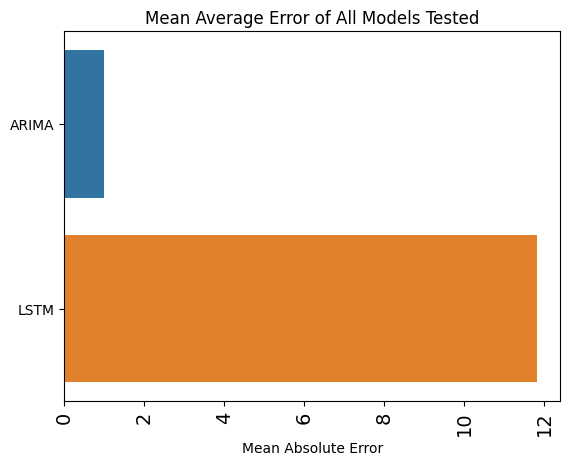

In [25]:
import seaborn as sns
# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')